In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
import pandas as pd
import os
from glob import glob
from datetime import datetime
import numpy as np
import dateparser
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [60]:
path = "/content/drive/MyDrive/Shared/tide_prediction_luiscorreia/tide_prediction_luiscorreia"
os.chdir(path)

In [6]:
fnames = glob("data/external/*")
fnames.sort()

fname_train, fname_test = fnames

In [7]:
tref = np.datetime64("1960-01-01")
parser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

kw = dict(
    header=11,
    sep=';',
    encoding='Latin-1',
    usecols = [0,1],
    names = ["time", "h"],
    parse_dates = ["time"],
    date_parser = parser,
    index_col = "time"
)

train = pd.read_csv(fname_train, **kw).to_xarray()
train = train.assign(hd = ("time", detrend(train["h"])))
train = train.assign_coords(time = (train.time - tref) / np.timedelta64(1, "h"))

test = pd.read_csv(fname_test, **kw).to_xarray()
test = test.assign(hd = ("time", detrend(test["h"])))
test = test.assign_coords(time = (test.time - tref) / np.timedelta64(1, "h"))

display(train)
display(test)

<xarray.Dataset>
Dimensions:  (time: 8783)
Coordinates:
  * time     (time) float64 2.112e+05 2.112e+05 2.112e+05 ... 2.2e+05 2.2e+05
Data variables:
    h        (time) int64 109 142 204 263 311 338 340 ... 275 220 160 113 91 110
    hd       (time) float64 -124.5 -91.45 -29.46 29.54 ... -130.3 -152.3 -133.3

<xarray.Dataset>
Dimensions:  (time: 1343)
Coordinates:
  * time     (time) float64 1.345e+05 1.345e+05 ... 1.358e+05 1.358e+05
Data variables:
    h        (time) int64 306 317 297 260 220 184 ... 170 207 267 306 307 298
    hd       (time) float64 63.01 74.02 54.03 17.04 ... 37.45 76.46 77.47 68.48

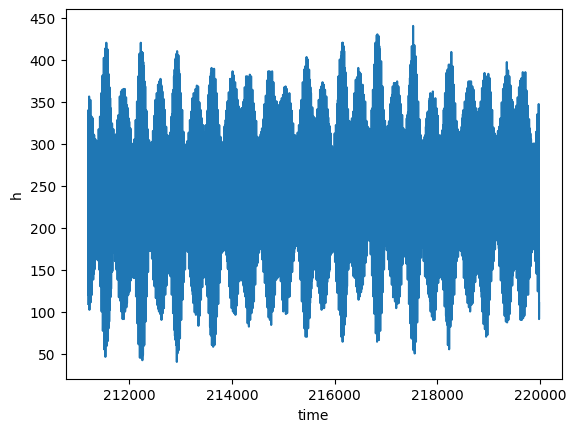

In [17]:
train.h.plot()

In [100]:
tide_constituents = {
    "M2": 12.4206012,
    "S2": 12,
    "N2": 12.65834751,
    "K1": 23.93447213,
    "O1": 25.81933871,
    "M4": 6.210300601,
    "M6": 4.140200401,
    "MK3": 8.177140247,
    "S4": 6,
    "MN4": 6.269173724
}

def estimate_tide(t, *amplitudes, tide_constituents = tide_constituents):
    a, b = np.array_split(amplitudes, 2)
    h = t * 0
    for k, ai, bi in zip(tide_constituents, a, b):
        w = 2 * np.pi / tide_constituents[k]
        h = h + ai * np.cos(w * t) + bi * np.sin(w * t)
    return h

In [101]:
# Initial guess for amplitudes
initial_amplitudes = np.random.rand(len(tide_constituents))
# initial_amplitudes = np.hstack(2 * [initial_amplitudes])

In [102]:
# Using curve_fit
params, _ = curve_fit(estimate_tide, train.time, train.hd, p0 = initial_amplitudes)
best_amplitudes = params

# amp = {k: np.abs(a + 1j*b) for k, a, b in zip(tide_constituents, *np.array_split(best_amplitudes, 2))}
# display(amp)

/usr/local/lib/python3.10/dist-packages/xarray/core/common.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self.values, dtype=dtype)


[Text(0.5, 1.0, 'rmse = 74.1 cm | corr = 0.87')]

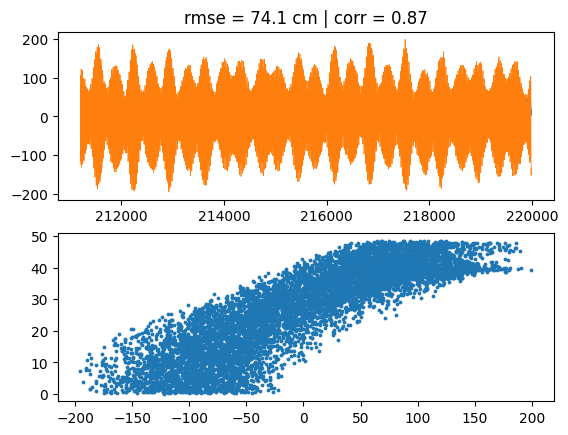

In [99]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(train.time, estimate_tide(train.time, *best_amplitudes), lw = 0.5)
ax[0].plot(train.time, train.hd, lw = 0.5)

rmse = np.sqrt(np.nanmean((train.hd - estimate_tide(train.time, *best_amplitudes)) ** 2))
rho = np.corrcoef(train.hd, estimate_tide(train.time, *best_amplitudes))[0,1]
ax[1].scatter(train.hd, estimate_tide(train.time, *best_amplitudes), s = 3)
ax[0].set(title = f"rmse = {rmse:.01f} cm | corr = {rho:.02f}")

[Text(0.5, 1.0, 'rmse = 19.4 cm | corr = 0.97')]

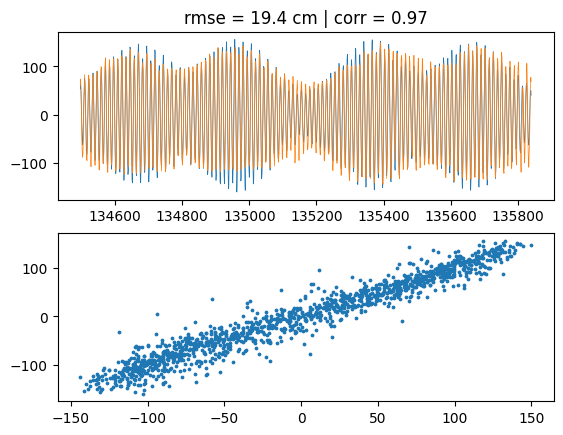

In [80]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(test.time, estimate_tide(test.time, *best_amplitudes), lw = 0.5)
ax[0].plot(test.time, test.hd, lw = 0.5)

rmse = np.sqrt(np.nanmean((test.hd - estimate_tide(test.time, *best_amplitudes)) ** 2))
rho = np.corrcoef(test.hd, estimate_tide(test.time, *best_amplitudes))[0,1]
ax[1].scatter(test.hd, estimate_tide(test.time, *best_amplitudes), s = 3)
ax[0].set(title = f"rmse = {rmse:.01f} cm | corr = {rho:.02f}")

0.9704906875965117